# 1. Data Preprocessing

## A. Importing the dataset

In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv('weatherAUS.csv')
dataset.head(5)

## B. Visualising and correcting the data

#### Firstly, we'll remove all rows with no labels

In [ ]:
print('Length before dropping nulls: ', len(dataset))
dataset.dropna(subset = ["RainTomorrow"], inplace = True)
print('Length after dropping nulls: ', len(dataset))

#### Secondly, we'll check if our data is balanced

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
rt = dataset.iloc[:, -2].values
numNo = np.count_nonzero(rt == 'No')
numYes = np.count_nonzero(rt == 'Yes')

In [ ]:
fig, ax = plt.subplots(figsize = (6,8))
plt.style.use('seaborn')
plt.bar(['No', 'Yes'], [numNo, numYes])

In [ ]:
dataset['RainTomorrow'][:10]

As we can see, our dataset is imbalanced. There is a split of nearly 77:23 for the classes No/Yes (after removing all nulls).

We'll look at over/under sampling our dataset later.

#### Next, we can label encode our labels (RainTomorrow) to 0 for No and 1 for Yes

In [ ]:
dataset.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset.iloc[:, -1] = le.fit_transform(dataset.iloc[:, -1])
dataset.iloc[:10,-1]


In [ ]:
dataset['RainToday'] = dataset['RainToday'].astype('category')
dataset['RainToday'] = dataset['RainToday'].cat.codes
dataset.head(10)

#### Let's look at our feature columns and calculate the missing data

In [ ]:
import seaborn

In [ ]:
numMissing = dataset.isnull().sum()
perMissing = numMissing/dataset.shape[0] * 100
df = {
    'Number of missing values' : numMissing,
    'Percentage of missing values' : perMissing,
    'Datatype' : dataset.dtypes
}
df = pd.DataFrame(df)
df

As we can see, 'Evaporation', 'Sunshine', 'Cloud9am', and 'Cloud3pm' have a very high percentage of missing values. We can try fitting them using mean or median imputation. 

#### Choosing between mean/median imputation by plotting the outliers

In [ ]:
boxplot = dataset.boxplot(column = ['Evaporation'])

In [ ]:
dataset.boxplot(column = ['Sunshine', 'Cloud9am', 'Cloud3pm'])

As we can see, the 'Evaporation' column has many outliers, whereas 'Sunshine', 'Cloud9am', and 'Cloud3pm' have no outliers. 

Thus, we can use median imputation for the missing values in the 'Evaporation' column, since outliers have little effect on medians. Mean Imputation will work well when there are no outliers.

Moreover, for better accuracy, we will set the median of each missing value to the median of the Evaporation column in each town.

In [ ]:
dataset.describe()

In [ ]:
dataset['Sunshine'] = dataset['Sunshine'].fillna(dataset['Sunshine'].mean())
dataset['Cloud9am'] = dataset['Cloud9am'].fillna(dataset['Cloud9am'].mean())
dataset['Cloud3pm'] = dataset['Cloud3pm'].fillna(dataset['Cloud3pm'].mean())
dataset['Evaporation'] = dataset['Evaporation'].fillna(dataset['Evaporation'].median())

#### Filling in the rest of the columns' missing data with the median data

In [ ]:
dataset['MinTemp'] = dataset['MinTemp'].fillna(dataset['MinTemp'].median())
dataset['MaxTemp'] = dataset['MaxTemp'].fillna(dataset['MaxTemp'].median())
dataset['Rainfall'] = dataset['Rainfall'].fillna(dataset['Rainfall'].median())
dataset['WindGustSpeed'] = dataset['WindGustSpeed'].fillna(dataset['WindGustSpeed'].median())
dataset['WindSpeed9am'] = dataset['WindSpeed9am'].fillna(dataset['WindSpeed9am'].median())
dataset['WindSpeed3pm'] = dataset['WindSpeed3pm'].fillna(dataset['WindSpeed3pm'].median())
dataset['Humidity9am'] = dataset['Humidity9am'].fillna(dataset['Humidity9am'].median())
dataset['Humidity3pm'] = dataset['Humidity3pm'].fillna(dataset['Humidity3pm'].median())
dataset['Pressure9am'] = dataset['Pressure9am'].fillna(dataset['Pressure9am'].median())
dataset['Pressure3pm'] = dataset['Pressure3pm'].fillna(dataset['Pressure3pm'].median())
dataset['Temp9am'] = dataset['Temp9am'].fillna(dataset['Temp9am'].median())
dataset['Temp3pm'] = dataset['Temp3pm'].fillna(dataset['Temp3pm'].median())

#### Filling in RainToday and WindDir columns missing data with the mode 

In [ ]:
dataset['RainToday'] = dataset['RainToday'].fillna(dataset['RainToday'].mode()[0])
dataset['WindDir9am'] = dataset['WindDir9am'].fillna(dataset['WindDir9am'].mode()[0])
dataset['WindGustDir'] = dataset['WindGustDir'].fillna(dataset['WindGustDir'].mode()[0])
dataset['WindDir3pm'] = dataset['WindDir3pm'].fillna(dataset['WindDir3pm'].mode()[0])

In [ ]:
numMissing = dataset.isnull().sum()
perMissing = numMissing/dataset.shape[0] * 100
df = {
    'Number of missing values' : numMissing,
    'Percentage of missing values' : perMissing,
    'Datatype' : dataset.dtypes
}
df = pd.DataFrame(df)
df

Our data doesn't contain anymore null values.

#### Printing the correlation matrix

In [ ]:
import seaborn
correlationMatrix = dataset.corr()
map = seaborn.diverging_palette(260, -10, as_cmap = True)
plt.subplots(figsize = (13, 13))
plt.title('Correlation Matrix')
seaborn.heatmap(correlationMatrix, cmap = map, annot = True, square = True)

We'll drop the columns that have a abs(correlation) of less than 0.1 with the RainTomorrow column.

In [ ]:
new_dataset = dataset.drop(['Location', 'MinTemp', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Temp9am'], axis = 1)

Also dropping the date column, as it has no meaning to our NNs.

In [ ]:
new_dataset.drop('Date', axis = 1, inplace = True)

In [ ]:
new_dataset.head()

## Creating our training and testing sets

#### Splitting our feature and labels

In [ ]:
x = new_dataset.iloc[:, :-1].values
y = new_dataset.iloc[:, -1].values
print(x.shape)
print(y.shape)

In [ ]:
print(x[300])

#### Scaling

We are going to use standard scaling as data obtained from nature is usually normally distributed, thus using standard scaling will not alter the characteristics of the dataset.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x[:, :-1] = sc.fit_transform(x[:, :-1])

In [ ]:
print(x[300])

#### Creating training and testing sets for our ANN/CNN

In [ ]:
from sklearn.model_selection import train_test_split
ann_X_train, ann_X_test, ann_Y_train, ann_Y_test = train_test_split(x,y, shuffle = True, test_size = 0.2)

ann_X_train = ann_X_train.reshape(-1, 15, 1)
ann_X_test = ann_X_test.reshape(-1, 15, 1)
print(ann_X_train.shape)
print(ann_X_test.shape)
print(ann_Y_train.shape)
print(ann_Y_test.shape)

#### Creating training tests and labels for our RNN

Note for the RNN, we are only predicting whether or not there is rain in a given amount of time after our training data (i.e. the time that takes place in our testing data).

We will be training 29 consecutive days and testing on the 30th day.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, shuffle = False, test_size = 0.2)
import numpy as np
rnn_X_train = []
rnn_Y_train = []
for i in range(30, X_train.shape[0]):
    rnn_X_train.append(X_train[i-30:i])
    rnn_Y_train.append(Y_train[i])
rnn_X_train, rnn_Y_train = np.array(rnn_X_train), np.array(rnn_Y_train)

rnn_X_test = []
rnn_Y_test = []
for i in range(30, X_test.shape[0]):
    rnn_X_test.append(X_test[i-30:i])
    rnn_Y_test.append(Y_test[i])
rnn_X_test, rnn_Y_test = np.array(rnn_X_test), np.array(rnn_Y_test)
rnn_X_train, rnn_Y_train = np.array(rnn_X_train), np.array(rnn_Y_train)
print(rnn_X_train.shape)
print(rnn_X_test.shape)
print(rnn_Y_train.shape)
print(rnn_Y_test.shape)

In [ ]:
rnn_X_train = rnn_X_train.reshape(-1, 30, 15)
rnn_X_test = rnn_X_test.reshape(-1, 30, 15)
print(rnn_X_train.shape)
print(rnn_X_test.shape)
print(rnn_Y_train.shape)
print(rnn_Y_test.shape)

## Creating the model

In [ ]:
import tensorflow as tf

For our model, since we are not using oversampling, we will be adding an initialization bias. We'll calculate the bias by finding the log of the positive/negative classes.

In [ ]:
neg, pos = np.bincount(dataset['RainTomorrow'])
print(neg)
print(pos)

In [ ]:
bias = np.log(pos/neg)
print(bias)
output_bias = tf.keras.initializers.Constant(bias)

#### Creating our ANN model

In [ ]:
ann_X_train = ann_X_train.reshape(-1, 15)
print(ann_X_train.shape)
from imblearn.over_sampling import SMOTE
smt = SMOTE(sampling_strategy=0.5)
os_ann_x_train, os_ann_y_train = smt.fit_resample(ann_X_train, ann_Y_train)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(sampling_strategy=0.5)
us_ann_x_train, us_ann_y_train = under.fit_resample(ann_X_train, ann_Y_train)

In [ ]:
us_ann_x_train = us_ann_x_train.reshape(-1, 15,1)

In [ ]:
print(us_ann_x_train.shape)

In [ ]:
print(ann_X_train.shape)

#### Creating our ANN model

In [222]:
ann_model = tf.keras.models.Sequential()

ann_model.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
ann_model.add(tf.keras.layers.Dropout(0.5))

ann_model.add(tf.keras.layers.Dense(units = 96, activation = 'relu'))
ann_model.add(tf.keras.layers.Dropout(0.5))

ann_model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
ann_model.add(tf.keras.layers.Dropout(0.5))

ann_model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid', bias_initializer=output_bias ))

ann_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [223]:
ann_history = ann_model.fit(ann_X_train.reshape(-1, 15), ann_Y_train, epochs = 15, batch_size = 32, validation_split = 0.2)

Epoch 1/15
2844/2844 [==============================] - 14s 4ms/step - loss: 0.3885 - accuracy: 0.8292 - val_loss: 0.3603 - val_accuracy: 0.8449
Epoch 2/15
2844/2844 [==============================] - 12s 4ms/step - loss: 0.3715 - accuracy: 0.8383 - val_loss: 0.3593 - val_accuracy: 0.8446
Epoch 3/15
2844/2844 [==============================] - 14s 5ms/step - loss: 0.3661 - accuracy: 0.8412 - val_loss: 0.3555 - val_accuracy: 0.8449
Epoch 4/15
2844/2844 [==============================] - 10s 4ms/step - loss: 0.3628 - accuracy: 0.8422 - val_loss: 0.3552 - val_accuracy: 0.8445
Epoch 5/15
2844/2844 [==============================] - 10s 4ms/step - loss: 0.3614 - accuracy: 0.8428 - val_loss: 0.3502 - val_accuracy: 0.8460
Epoch 6/15
2844/2844 [==============================] - 11s 4ms/step - loss: 0.3594 - accuracy: 0.8434 - val_loss: 0.3510 - val_accuracy: 0.8457
Epoch 7/15
2844/2844 [==============================] - 11s 4ms/step - loss: 0.3589 - accuracy: 0.8453 - val_loss: 0.3493 - val_ac

We are going to use standard scaling as data obtained from nature is usually normally distributed, thus using standard scaling will not alter the characteristics of the dataset.

In [224]:
def generate_predicted(model, X_test):
    # Get the predictions
    Y_pred = model.predict(X_test)
    # Create a list of predictions
    print(Y_pred.shape)
    #Converting predictions to label
    predicted = [0 if Y_pred[i]<0.5 else 1 for i in range(len(Y_pred))]


    return predicted

predicted = generate_predicted(ann_model, ann_X_test.reshape(-1, 15))

(28439, 1)


In [225]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ann_Y_test,predicted)
print(cm)

[[21453   540]
 [ 3867  2579]]


In [226]:
from sklearn.metrics import accuracy_score
print('Accuracy score:\t\t', accuracy_score(ann_Y_test, predicted))

from sklearn.metrics import f1_score
print('F1 score:\t\t', f1_score(ann_Y_test, predicted, average='macro'))

from sklearn.metrics import precision_score
print('Precision score:\t', precision_score(ann_Y_test, predicted, average='macro'))

from sklearn.metrics import recall_score
print('Recall score:\t\t', recall_score(ann_Y_test, predicted, average='macro'))

from sklearn.metrics import classification_report
print(classification_report(ann_Y_test, predicted))

Accuracy score:		 0.8450367453145329
F1 score:		 0.7230560316643831
Precision score:	 0.8370712336406279
Recall score:		 0.6877699070159392
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     21993
           1       0.83      0.40      0.54      6446

    accuracy                           0.85     28439
   macro avg       0.84      0.69      0.72     28439
weighted avg       0.84      0.85      0.82     28439



(28439, 1)


,AUC
0,0.879872


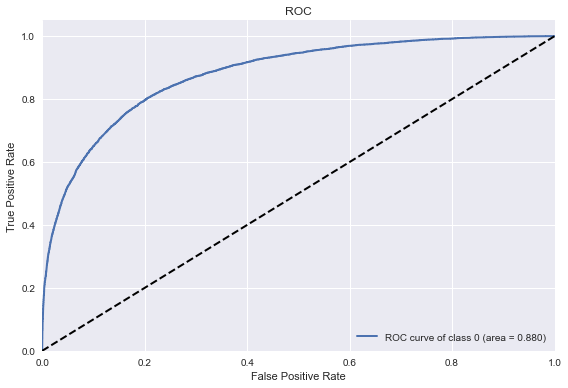

In [227]:
# we already have actual and predicted 

# also see https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
# for micro-average ROC curves as well

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1  # one hot encoded

y_score=ann_model.predict(ann_X_test.reshape(-1, 15), batch_size=None, verbose=0, steps=None)
print(y_score.shape)

# compare each class's probabilities one by one
# each acts like a single column
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ann_Y_test[:], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print the AUC scores
from IPython.display import display
import pandas as pd
auc_array = np.array(list(roc_auc.items()))
df = pd.DataFrame(auc_array[:,1])
df.columns = ['AUC']
display(df)

# Draw the pairwise ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.3f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC.png')
plt.show()

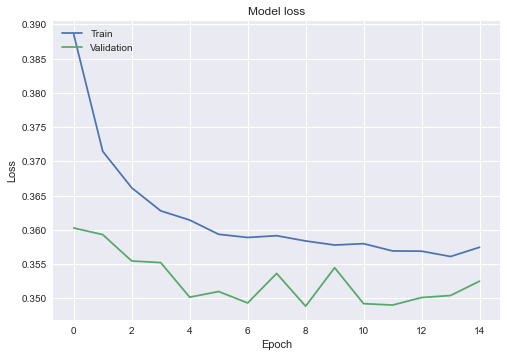

In [228]:
# Plotting the loss over time
plt.plot(ann_history.history['loss']) 
plt.plot(ann_history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

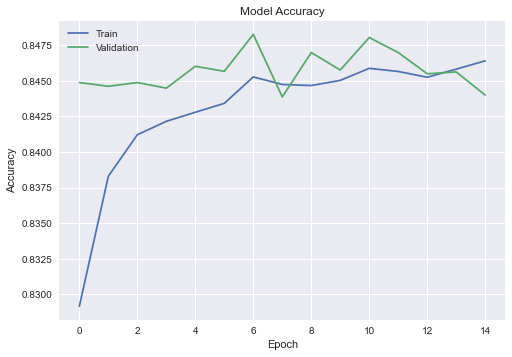

In [229]:
# Plotting the accuracy over time
plt.plot(ann_history.history['accuracy']) 
plt.plot(ann_history.history['val_accuracy']) 
plt.title('Model Accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

## CNN

In [232]:
ann_X_train = ann_X_train.reshape(-1,15,1)

In [235]:
cnn_model = tf.keras.models.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters = 32, kernel_size = 3))
cnn_model.add(tf.keras.layers.BatchNormalization(center=True, scale=False))
cnn_model.add(tf.keras.layers.Activation('relu'))
                  
cnn_model.add(tf.keras.layers.Conv1D(filters = 64, kernel_size = 3))
cnn_model.add(tf.keras.layers.BatchNormalization(center=True, scale=False))
cnn_model.add(tf.keras.layers.Activation('relu'))

cnn_model.add(tf.keras.layers.Conv1D(filters = 96, kernel_size = 3))
cnn_model.add(tf.keras.layers.BatchNormalization(center=True, scale=False))
cnn_model.add(tf.keras.layers.Activation('relu'))

cnn_model.add(tf.keras.layers.Flatten())
          
cnn_model.add(tf.keras.layers.Dense(units = 128))
cnn_model.add(tf.keras.layers.BatchNormalization(center=True, scale=False))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
          
cnn_model.add(tf.keras.layers.Dense(units = 64))
cnn_model.add(tf.keras.layers.BatchNormalization(center=True, scale=False))
cnn_model.add(tf.keras.layers.Activation('relu'))
cnn_model.add(tf.keras.layers.Dropout(0.5))
          
cnn_model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid', bias_initializer=output_bias))

cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [236]:
cnn_history = cnn_model.fit(ann_X_train.reshape(-1, 15,1), ann_Y_train, epochs = 30, batch_size = 32, validation_split = 0.2)

Epoch 1/30
2844/2844 [==============================] - 41s 13ms/step - loss: 0.3902 - accuracy: 0.8303 - val_loss: 0.3581 - val_accuracy: 0.8460
Epoch 2/30
2844/2844 [==============================] - 36s 13ms/step - loss: 0.3715 - accuracy: 0.8366 - val_loss: 0.3544 - val_accuracy: 0.8455 loss: 0.3713 - accu
Epoch 3/30
2844/2844 [==============================] - 35s 12ms/step - loss: 0.3674 - accuracy: 0.8400 - val_loss: 0.3548 - val_accuracy: 0.8460
Epoch 4/30
2844/2844 [==============================] - 37s 13ms/step - loss: 0.3620 - accuracy: 0.8409 - val_loss: 0.3504 - val_accuracy: 0.8471
Epoch 5/30
2844/2844 [==============================] - 33s 11ms/step - loss: 0.3618 - accuracy: 0.8429 - val_loss: 0.3498 - val_accuracy: 0.8468
Epoch 6/30
2844/2844 [==============================] - 27s 10ms/step - loss: 0.3591 - accuracy: 0.8436 - val_loss: 0.3470 - val_accuracy: 0.8496
Epoch 7/30
2844/2844 [==============================] - 27s 9ms/step - loss: 0.3566 - accuracy: 0.8451 -

In [237]:
def generate_predicted(model, X_test):
    # Get the predictions
    Y_pred = model.predict(X_test)
    # Create a list of predictions
    print(Y_pred.shape)
    #Converting predictions to label
    predicted = [0 if Y_pred[i]<0.5 else 1 for i in range(len(Y_pred))]


    return predicted

predicted = generate_predicted(cnn_model, ann_X_test.reshape(-1, 15, 1))

(28439, 1)


In [238]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ann_Y_test,predicted)
print(cm)

[[20836  1157]
 [ 3043  3403]]


In [239]:
from sklearn.metrics import accuracy_score
print('Accuracy score:\t\t', accuracy_score(ann_Y_test, predicted))

from sklearn.metrics import f1_score
print('F1 score:\t\t', f1_score(ann_Y_test, predicted, average='macro'))

from sklearn.metrics import precision_score
print('Precision score:\t', precision_score(ann_Y_test, predicted, average='macro'))

from sklearn.metrics import recall_score
print('Recall score:\t\t', recall_score(ann_Y_test, predicted, average='macro'))

from sklearn.metrics import classification_report
print(classification_report(ann_Y_test, predicted))

Accuracy score:		 0.8523154822602764
F1 score:		 0.7634154240376607
Precision score:	 0.8094188913329851
Recall score:		 0.737658323123967
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     21993
           1       0.75      0.53      0.62      6446

    accuracy                           0.85     28439
   macro avg       0.81      0.74      0.76     28439
weighted avg       0.84      0.85      0.84     28439



(28439, 1)


,AUC
0,0.880295


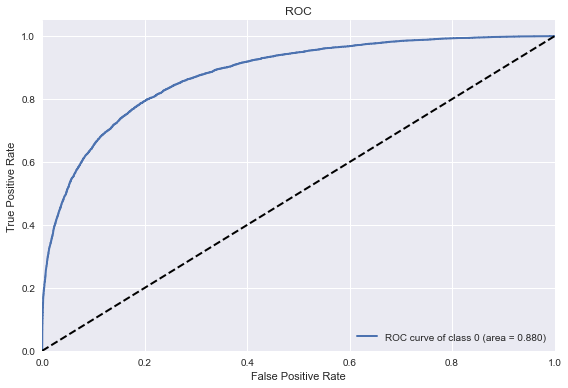

In [240]:
# we already have actual and predicted 

# also see https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
# for micro-average ROC curves as well

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1  # one hot encoded

y_score=cnn_model.predict(ann_X_test.reshape(-1, 15, 1), batch_size=None, verbose=0, steps=None)
print(y_score.shape)

# compare each class's probabilities one by one
# each acts like a single column
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ann_Y_test[:], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print the AUC scores
from IPython.display import display
import pandas as pd
auc_array = np.array(list(roc_auc.items()))
df = pd.DataFrame(auc_array[:,1])
df.columns = ['AUC']
display(df)

# Draw the pairwise ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.3f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC.png')
plt.show()

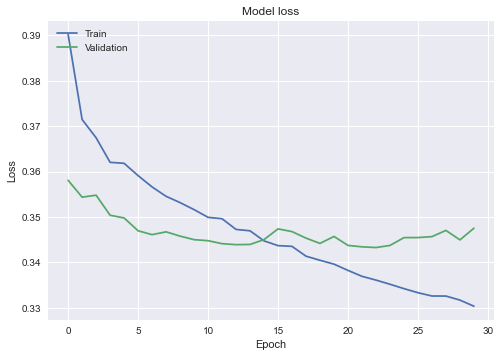

In [241]:
# Plotting the loss over time
plt.plot(cnn_history.history['loss']) 
plt.plot(cnn_history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

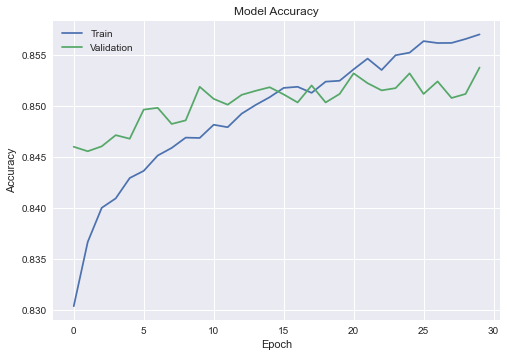

In [242]:
# Plotting the accuracy over time
plt.plot(cnn_history.history['accuracy']) 
plt.plot(cnn_history.history['val_accuracy']) 
plt.title('Model Accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

#### Creating our RNN model

In [248]:
rnn = tf.keras.models.Sequential()

rnn.add(tf.keras.layers.GRU(units = 64, return_sequences = True))
rnn.add(tf.keras.layers.Dropout(rate = 0.2))

rnn.add(tf.keras.layers.GRU(units = 32))
rnn.add(tf.keras.layers.Dropout(rate = 0.2))

rnn.add(tf.keras.layers.Dense(1, bias_initializer = output_bias, activation = 'sigmoid'))

In [249]:
rnn.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])

In [250]:
rnn_history = rnn.fit(rnn_X_train, rnn_Y_train, validation_split = 0.2, epochs = 10, batch_size = 256)

Epoch 1/10
356/356 [==============================] - 60s 148ms/step - loss: 0.1682 - accuracy: 0.7686 - val_loss: 0.1528 - val_accuracy: 0.7837
Epoch 2/10
356/356 [==============================] - 52s 147ms/step - loss: 0.1648 - accuracy: 0.7696 - val_loss: 0.1462 - val_accuracy: 0.7913
Epoch 3/10
356/356 [==============================] - 53s 148ms/step - loss: 0.1631 - accuracy: 0.7712 - val_loss: 0.1452 - val_accuracy: 0.7935
Epoch 4/10
356/356 [==============================] - 53s 148ms/step - loss: 0.1619 - accuracy: 0.7727 - val_loss: 0.1440 - val_accuracy: 0.7942
Epoch 5/10
356/356 [==============================] - 54s 151ms/step - loss: 0.1607 - accuracy: 0.7743 - val_loss: 0.1440 - val_accuracy: 0.7959
Epoch 6/10
356/356 [==============================] - 53s 149ms/step - loss: 0.1598 - accuracy: 0.7744 - val_loss: 0.1412 - val_accuracy: 0.8020
Epoch 7/10
356/356 [==============================] - 53s 148ms/step - loss: 0.1590 - accuracy: 0.7762 - val_loss: 0.1419 - val_ac

In [251]:
def generate_predicted(model, X_test):
    # Get the predictions
    Y_pred = model.predict(X_test)
    # Create a list of predictions
    print(Y_pred.shape)
    #Converting predictions to label
    predicted = [0 if Y_pred[i]<0.5 else 1 for i in range(len(Y_pred))]


    return predicted

predicted = generate_predicted(rnn, rnn_X_test)

(28409, 1)


In [252]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(rnn_Y_test,predicted)
print(cm)

[[21946   722]
 [ 4790   951]]


In [253]:
from sklearn.metrics import accuracy_score
print('Accuracy score:\t\t', accuracy_score(rnn_Y_test, predicted))

from sklearn.metrics import f1_score
print('F1 score:\t\t', f1_score(rnn_Y_test, predicted, average='macro'))

from sklearn.metrics import precision_score
print('Precision score:\t', precision_score(rnn_Y_test, predicted, average='macro'))

from sklearn.metrics import recall_score
print('Recall score:\t\t', recall_score(rnn_Y_test, predicted, average='macro'))

from sklearn.metrics import classification_report
print(classification_report(rnn_Y_test, predicted))

Accuracy score:		 0.8059769791263333
F1 score:		 0.5724858822696621
Precision score:	 0.6946403710782331
Recall score:		 0.5668997579688874
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     22668
           1       0.57      0.17      0.26      5741

    accuracy                           0.81     28409
   macro avg       0.69      0.57      0.57     28409
weighted avg       0.77      0.81      0.76     28409



(28409, 1)


,AUC
0,0.458483


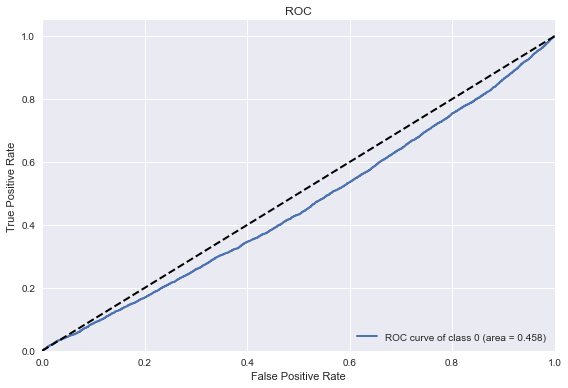

In [254]:
# we already have actual and predicted 

# also see https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/
# for micro-average ROC curves as well

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 1  # one hot encoded

y_score=model.predict(rnn_X_test, batch_size=None, verbose=0, steps=None)
print(y_score.shape)

# compare each class's probabilities one by one
# each acts like a single column
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(rnn_Y_test[:], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print the AUC scores
from IPython.display import display
import pandas as pd
auc_array = np.array(list(roc_auc.items()))
df = pd.DataFrame(auc_array[:,1])
df.columns = ['AUC']
display(df)

# Draw the pairwise ROC curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,label='ROC curve of class {0} (area = {1:0.3f})'
    ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('ROC.png')
plt.show()

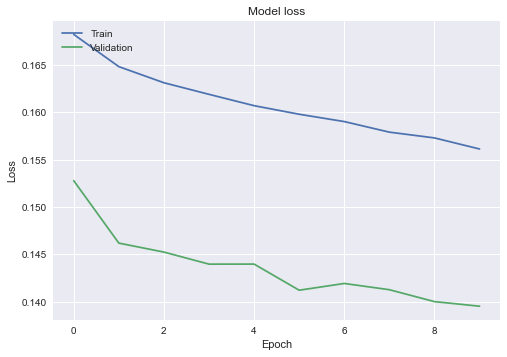

In [255]:
# Plotting the loss over time
plt.plot(rnn_history.history['loss']) 
plt.plot(rnn_history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

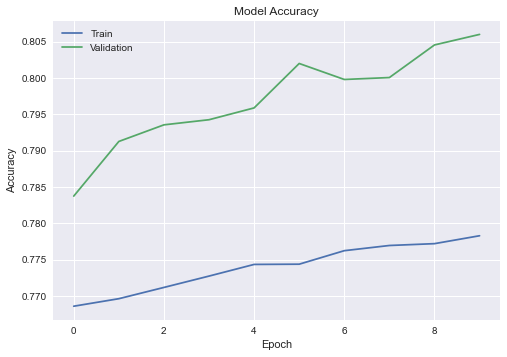

In [256]:
# Plotting the accuracy over time
plt.plot(rnn_history.history['accuracy']) 
plt.plot(rnn_history.history['val_accuracy']) 
plt.title('Model Accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()